In [1]:
import numpy as np
from geometricus import GeometricusEmbedding, MomentType, MomentInvariants
import prody as pd
from umap import UMAP
from pathlib import Path
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import networkx as nx
from geometricus_deeplearning import utils, embedder
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2


In [4]:
# pdb_folder = "./ecod/"
# invariants1 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
#                                         size=30)
# print("invariants1 extracted")
# invariants2 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.RADIUS,
#                                               size=10)
# print("invariants2 extracted")

# invariants = {k: cath.MomentInvariantsSavable.from_invariant(cath.concat_invariants(v, invariants2[k])) for k, v in invariants1.items()}

invariants1 extracted
invariants2 extracted


In [2]:
import pickle
invariants = pickle.load(open("ecod_invariants.pkl", "rb"))

In [3]:
# import pickle
# pickle.dump(invariants, open("ecod_invariants.pkl", "wb"))
single_invariant = invariants[list(invariants.keys())[0]]

In [10]:
domain_info = utils.EcodInfo.from_ecod_class_file().ecod_classification

In [48]:
mappings = {f"{k}.pdbnum.pdb": f"{v.f_id}" for k, v in domain_info.items() if f"{k}.pdbnum.pdb" in invariants}
keys, counts = np.unique(list(mappings.values()), return_counts=True)
least_allowed_class_count = 20
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
mappings = {k: v for k, v in mappings.items() if v in keys_to_use}
len(keys_to_use), len(mappings)

(7031, 44328)

In [50]:
# del train_data, test_data
torch.cuda.empty_cache()
train_data, test_data = embedder.transform_geometricus_dataset_for_training(mappings,
                                                                        invariants, batch_no=1028)

In [33]:
torch.cuda.empty_cache()

In [42]:
model = embedder.train_model(
    train_data,
    test_data,
    number_of_node_features=single_invariant.moments.shape[1],
    hidden_channels=128,
    number_of_classes=len(keys_to_use),
    lr=0.005,
    epochs=1000,
)

Initial: Train Acc: 0.0000, Test Acc: 0.0000
Epoch: 010, Train Acc: 0.2151, Test Acc: 0.1978
Epoch: 020, Train Acc: 0.4943, Test Acc: 0.4436
Epoch: 030, Train Acc: 0.6189, Test Acc: 0.5518
Epoch: 040, Train Acc: 0.6812, Test Acc: 0.6094
Epoch: 050, Train Acc: 0.7223, Test Acc: 0.6432
Epoch: 060, Train Acc: 0.7634, Test Acc: 0.6780
Epoch: 070, Train Acc: 0.7885, Test Acc: 0.6996
Epoch: 080, Train Acc: 0.8066, Test Acc: 0.7110
Epoch: 090, Train Acc: 0.8275, Test Acc: 0.7227
Epoch: 100, Train Acc: 0.8403, Test Acc: 0.7306
Epoch: 110, Train Acc: 0.8472, Test Acc: 0.7377
Epoch: 120, Train Acc: 0.8586, Test Acc: 0.7475
Epoch: 130, Train Acc: 0.8652, Test Acc: 0.7527
Epoch: 140, Train Acc: 0.8753, Test Acc: 0.7600
Epoch: 150, Train Acc: 0.8805, Test Acc: 0.7601
Epoch: 160, Train Acc: 0.8823, Test Acc: 0.7618
Epoch: 170, Train Acc: 0.8879, Test Acc: 0.7671
Epoch: 180, Train Acc: 0.8931, Test Acc: 0.7670
Epoch: 190, Train Acc: 0.8999, Test Acc: 0.7744
Epoch: 200, Train Acc: 0.9016, Test Acc: 0.

In [43]:
torch.save(model, "ecod_embedder.pth")

In [16]:
model = torch.load("ecod_embedder.pth")
model.eval()

GCN(
  (conv1): GraphConv(32, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=364, bias=True)
)

In [17]:
from sklearn import metrics

In [18]:
def get_embedding(loaders, model):
    model.eval()
    res = list()
    labels = []
    predicted_labels = []
    for loader in loaders:
        for data in loader:
            data = data.cuda()
            out = model(data.x, data.edge_index, data.batch)
            res.append(out.cpu().detach().numpy())
            labels.append(data.y.cpu().detach().numpy())
            predicted_labels.append(out.argmax(dim=1).cpu().detach().numpy())
    return np.concatenate(res), np.concatenate(labels), np.concatenate(predicted_labels)

In [19]:
import umap

In [51]:
pytorch_embedding, labels, pred = get_embedding([train_data, test_data], model)
pytorch_embedding.shape, labels.shape, pred.shape

((5068, 364), (5068,), (5068,))

In [52]:
torch.cuda.empty_cache()

In [53]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

In [54]:
# from sklearn.metrics import confusion_matrix
# import itertools

# confusionMatrix = confusion_matrix(labels, pred)

# confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
# np.set_printoptions(precision=2)
# plt.figure(figsize=(20,20))
# plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion matrix')
# plt.colorbar()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()


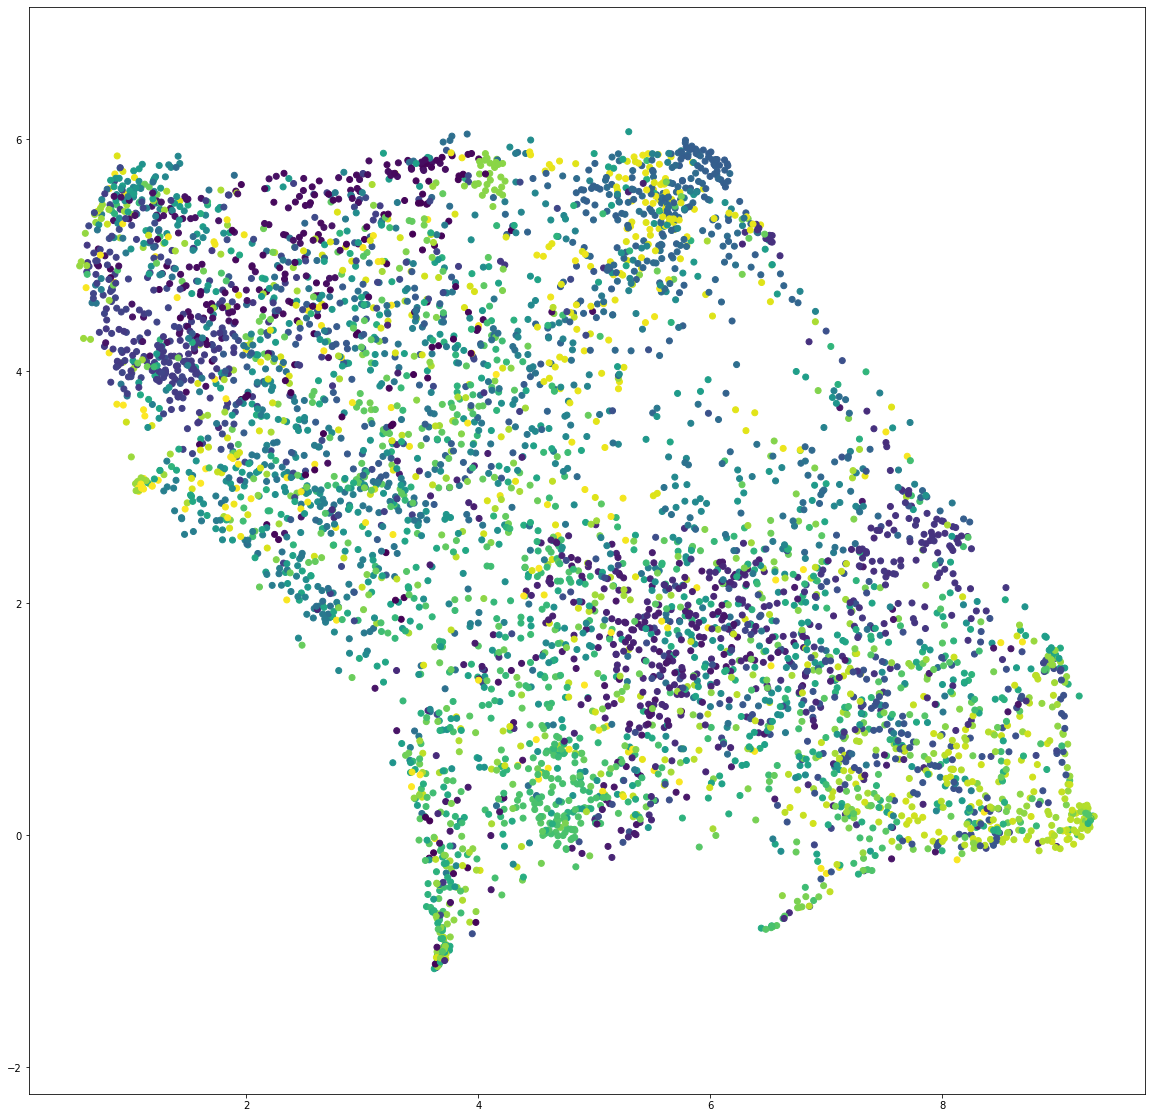

In [55]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [56]:
from sklearn import metrics

true_ecod, pred_ecod = list(), list()
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            true_ecod.append(1)
        else:
            true_ecod.append(0)

In [57]:
pred_ecod = metrics.pairwise_distances(embedding).flatten()
pred_ecod = pred_ecod.max() - pred_ecod

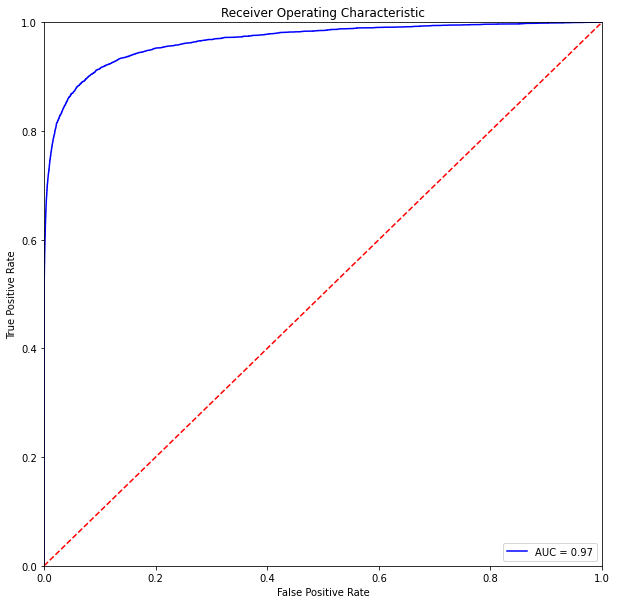

In [58]:
fpr, tpr, threshold = metrics.roc_curve(true_ecod, pred_ecod)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
cath_model = torch.load("embedder.pth") # this used the upsampled radius method..
cath_model.eval()

GCN(
  (conv1): GraphConv(32, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=116, bias=True)
)

In [69]:
pytorch_embedding, labels, pred = get_embedding([test_data], cath_model)
pytorch_embedding.shape, labels.shape, pred.shape

((2770, 116), (2770,), (2770,))

In [70]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

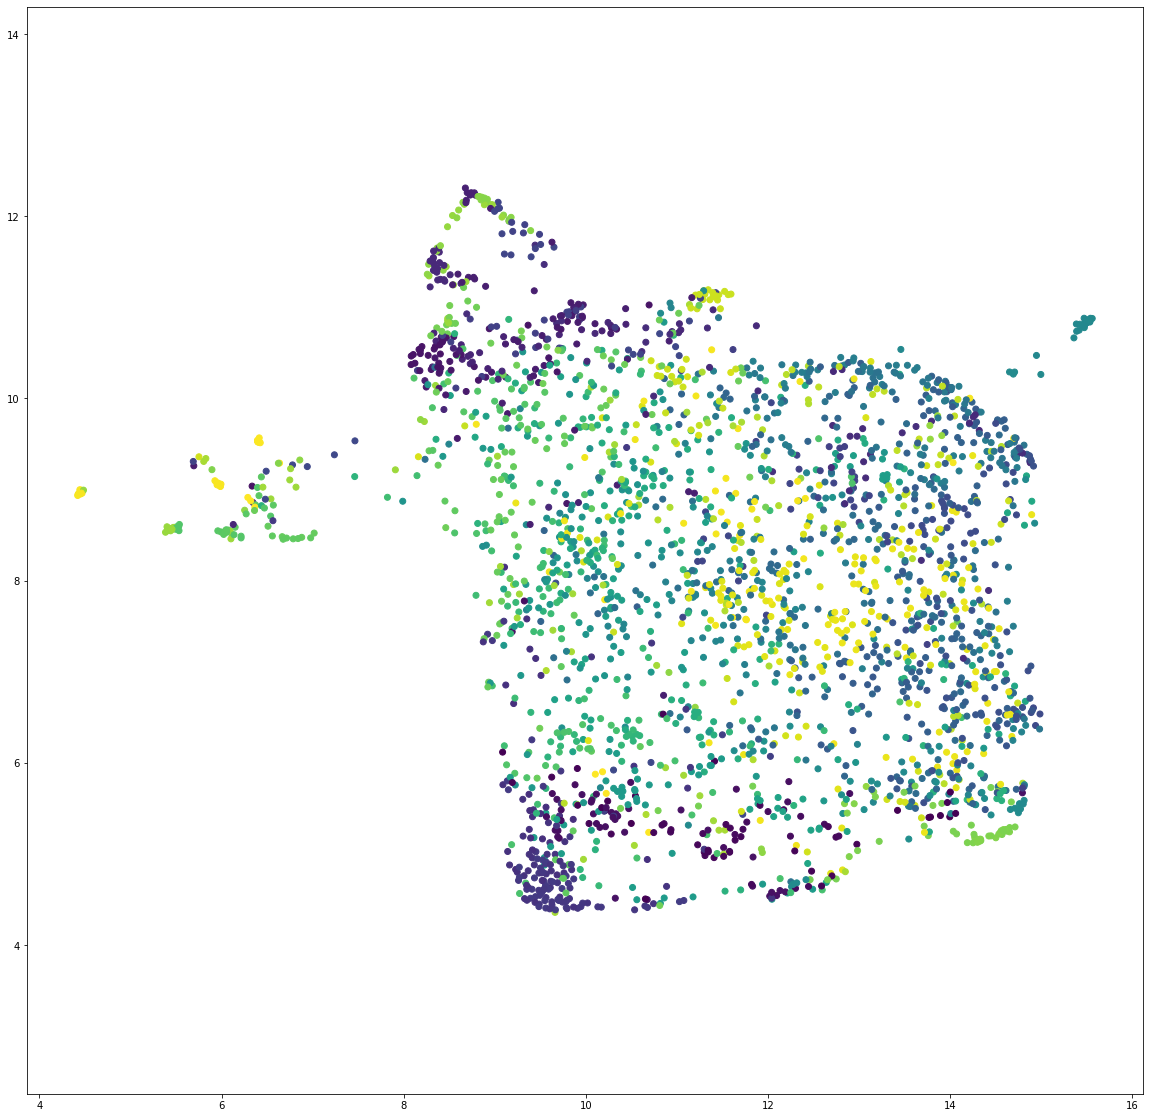

In [71]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [72]:
true_ecod, pred_ecod = list(), list()
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            true_ecod.append(1)
        else:
            true_ecod.append(0)

In [73]:
pred_ecod = metrics.pairwise_distances(embedding).flatten()
pred_ecod = pred_ecod.max() - pred_ecod

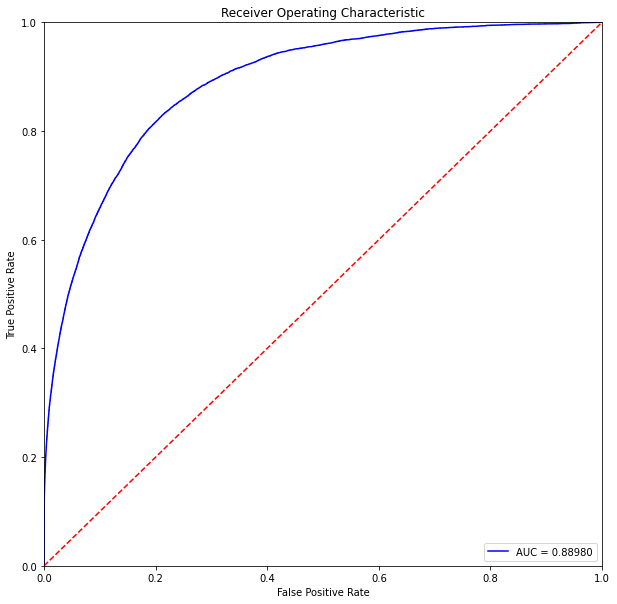

In [74]:
fpr, tpr, threshold = metrics.roc_curve(true_ecod, pred_ecod)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()